In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN
rng = np.random.RandomState(42)
def frequency_generator(N,min_period,max_period,n_changepoints):
    """returns a random step function with N changepoints
       and a sine wave signal that changes its frequency at
       each such step, in the limits given by min_ and max_period."""
    # vector of random indices < N, padded with 0 and N at the ends:
    changepoints = np.insert(np.sort(rng.randint(0,N,n_changepoints)),[0,n_changepoints],[0,N])
    # list of interval boundaries between which the control sequence should be constant:
    const_intervals = list(zip(changepoints,np.roll(changepoints,-1)))[:-1]
    # populate a control sequence
    f1 = np.zeros((N,1))
    for (t0,t1) in const_intervals:
        f1[t0:t1] = rng.rand()
    periods = f1 * (max_period - min_period) + max_period
    # run time through a sine, while changing the period length
    frequency_output = np.zeros((N,1))
    z = 0
    for i in range(N):
        z = z + 2 * np.pi / periods[i]
        frequency_output[i] = (np.sin(z) + 1)/2
    return np.hstack([np.ones((N,1)),frequency_output]),1-f1


N = 10000 # signal length
min_period = 2
max_period = 10
n_changepoints = int(N/200)
frequency_control,frequency_output = frequency_generator(N,min_period,max_period,n_changepoints)

traintest_cutoff = int(np.ceil(0.7*N))

train_ctrl,train_output = frequency_control[:traintest_cutoff],frequency_output[:traintest_cutoff]
test_ctrl, test_output  = frequency_control[traintest_cutoff:],frequency_output[traintest_cutoff:]

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


In [ ]:
import numpy as np

def identity(x):
    return x
@np.vectorize
def relu(x):
    return max(0,x)
class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=2,
                 spectral_radius=0.95, sparsity=0,random_state=None,teacher_forcing=False,noise=0,input_scaling=None,input_shift=None,teacher_scaling=None,teacher_shift=None):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.random_state = random_state
        self.teacher_forcing = teacher_forcing
        self.noise = noise
        self.input_scaling = input_scaling
        self.input_shift = input_shift
        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift
        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.initweights()
    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (relu(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs
    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher
    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled
    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))  
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1
        
        # print(f'W_in: {self.W_in}')
        # print(f'W: {self.W}')
        
    def fit(self, inputs, outputs, inspect=False):
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])
        
        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        
        # Fit Model
        self.model = keras.Sequential([
            keras.layers.Dense(units=64,activation='tanh',input_shape=(self.n_reservoir+self.n_inputs,)),
            keras.layers.Dense(units=64,activation='tanh'),
            keras.layers.Dense(units=64,activation='tanh'),
            keras.layers.Dense(units=1,activation='linear')
        ])
        MAX_EPOCHS = 1000

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                        patience=10,
                                                        mode='min')
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])
        
        history = self.model.fit(extended_states[transient:],teachers_scaled[transient:],epochs=MAX_EPOCHS,callbacks=[early_stopping],verbose=1)
        # # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]
        
        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.model.predict(extended_states))
        print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train
    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]
        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            extended_states = np.hstack((states[n + 1, :], inputs[n + 1, :])).reshape(1,-1)
            outputs[n + 1, :] = self.model.predict(extended_states,verbose=0)
        return self._unscale_teacher(outputs[1:])

In [ ]:
esn = ESN(n_inputs=2,n_outputs=1,n_reservoir=200,sparsity=.9)

In [ ]:
pred_train = esn.fit(train_ctrl,train_output)

In [ ]:
y_pred = esn.predict(test_ctrl)

In [ ]:
import pandas as pd
import plotly.express as px
fig = px.line(pd.DataFrame([test_output.squeeze(),y_pred.squeeze()]).T)
fig.show(renderer='browser')

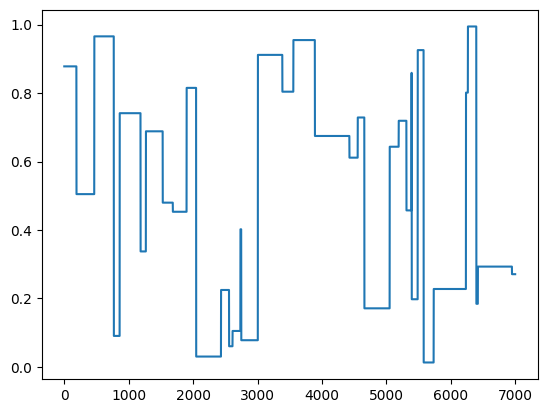

In [29]:
# plt.plot(train_ctrl)
plt.plot(train_output)
# plt.plot(pred_train)